# Medical Cost Personal
Project by Shani Bronshtein and Renato Dunaevits

The objective of this project is to predict an individual health insurance cost by given some parameters like age, gender, and BMI.

#### Columns
* Age: age of the primary beneficiary

* Sex: insurance contractor gender (male/female)

* BMI: Body mass index, ( weight/(height^2) ), ideally 18.5 to 24.9

* Children: Number of dependents

* Smoker: Smoking (yes/no)

* Region: the beneficiary's residential area in the US (northeast, southeast, southwest, northwest)

* Charges: Individual medical costs billed by health insurance

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split as split
import warnings
from sys import modules
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder#
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree, export_graphviz
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import pairwise_distances


warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split

from scipy.optimize import curve_fit

# Data loading

In [2]:
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Exploratory Data Analysis

### - Basic analysis

In [3]:
insurance.shape

(1338, 7)

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The data has 2 parameter integers, 2 floats and 3 objects. None of the parameters have a null row.

In [5]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### - Analysis of parameters distribution 

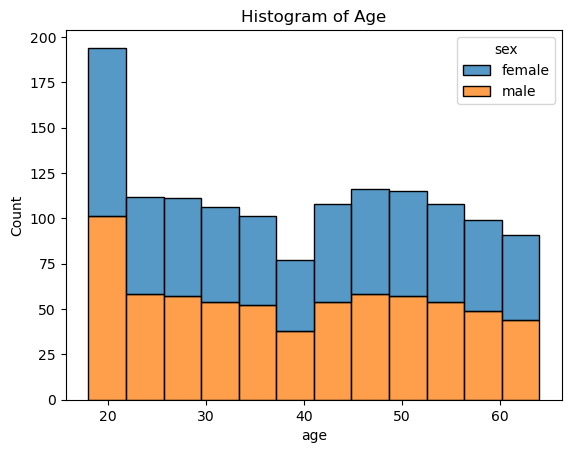

In [6]:
sns.histplot(data=insurance,x='age',hue='sex',multiple='stack')
plt.title('Histogram of Age')
plt.show()

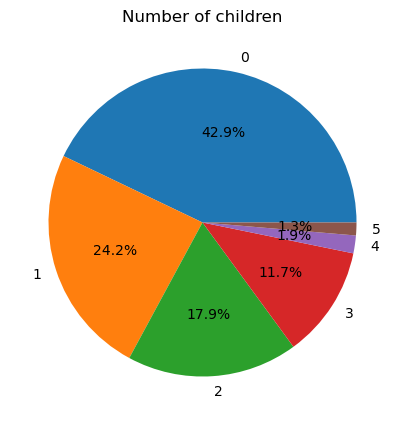

In [7]:
plt.figure(figsize=(10,5))
insurance['children'].value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title('Number of children')
plt.ylabel("")
plt.show()

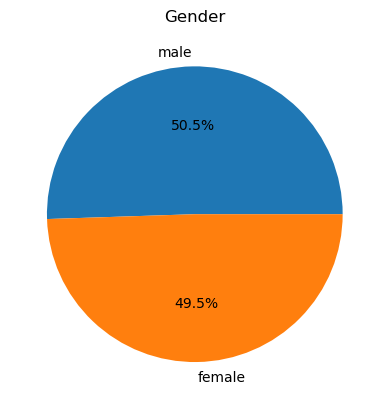

In [8]:
insurance['sex'].value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title('Gender')
plt.ylabel("")
plt.show()

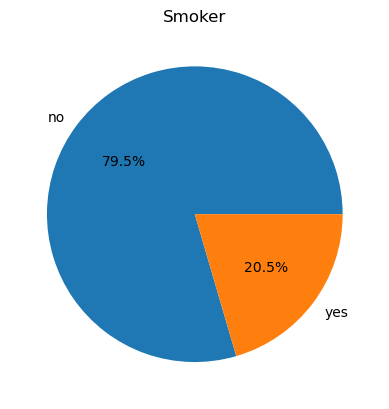

In [9]:
insurance['smoker'].value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title('Smoker')
plt.ylabel("")
plt.show()

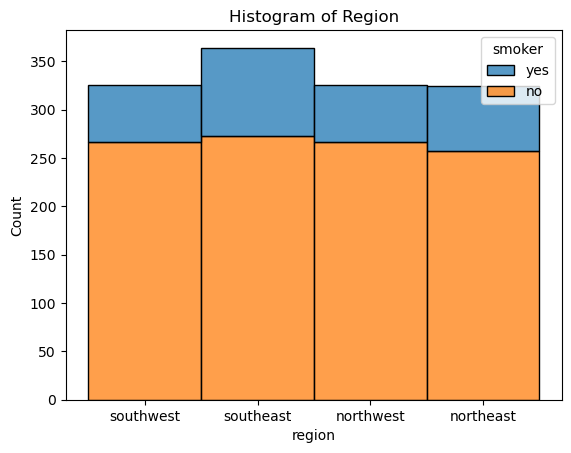

In [10]:
sns.histplot(data=insurance,x='region',hue='smoker', multiple = 'stack')
plt.title('Histogram of Region')
plt.show()

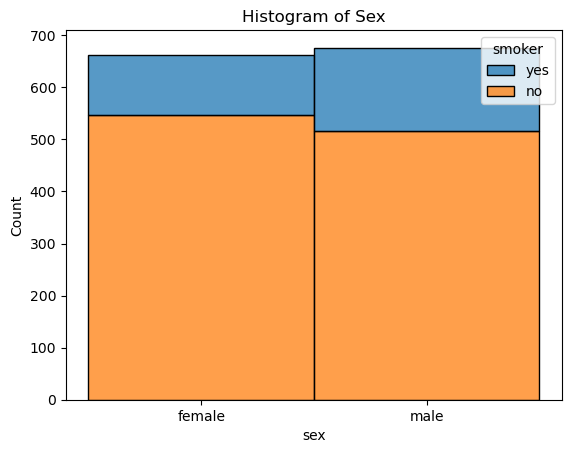

In [11]:
sns.histplot(data=insurance,x='sex',hue='smoker', multiple = 'stack')
plt.title('Histogram of Sex')
plt.show()

### - Basics analysis of charges amount by parameters

In [12]:
def box(param):
    fig, axes = plt.subplots(figsize=(15,10))
    return sns.boxplot(y=insurance.charges,x=insurance[param])

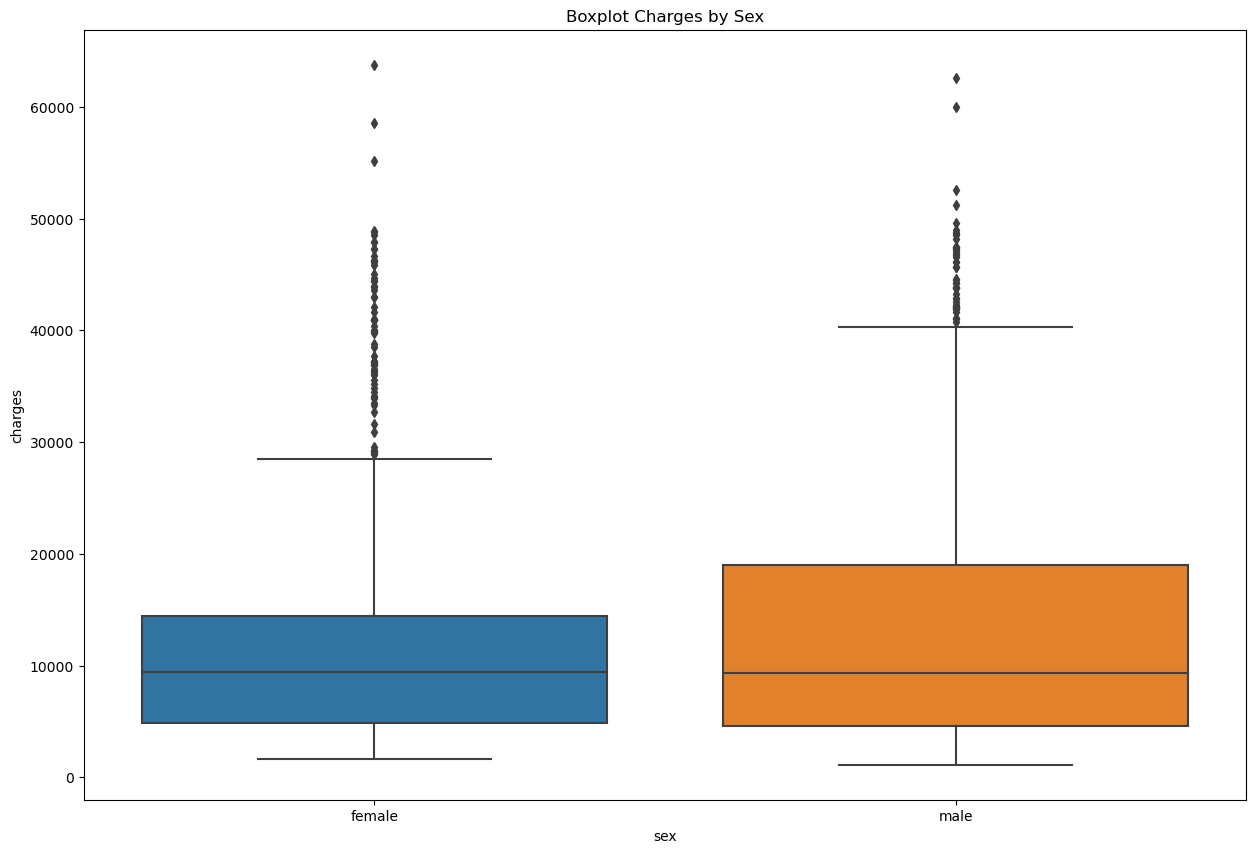

In [13]:
box('sex')
plt.title("Boxplot Charges by Sex")
plt.show()

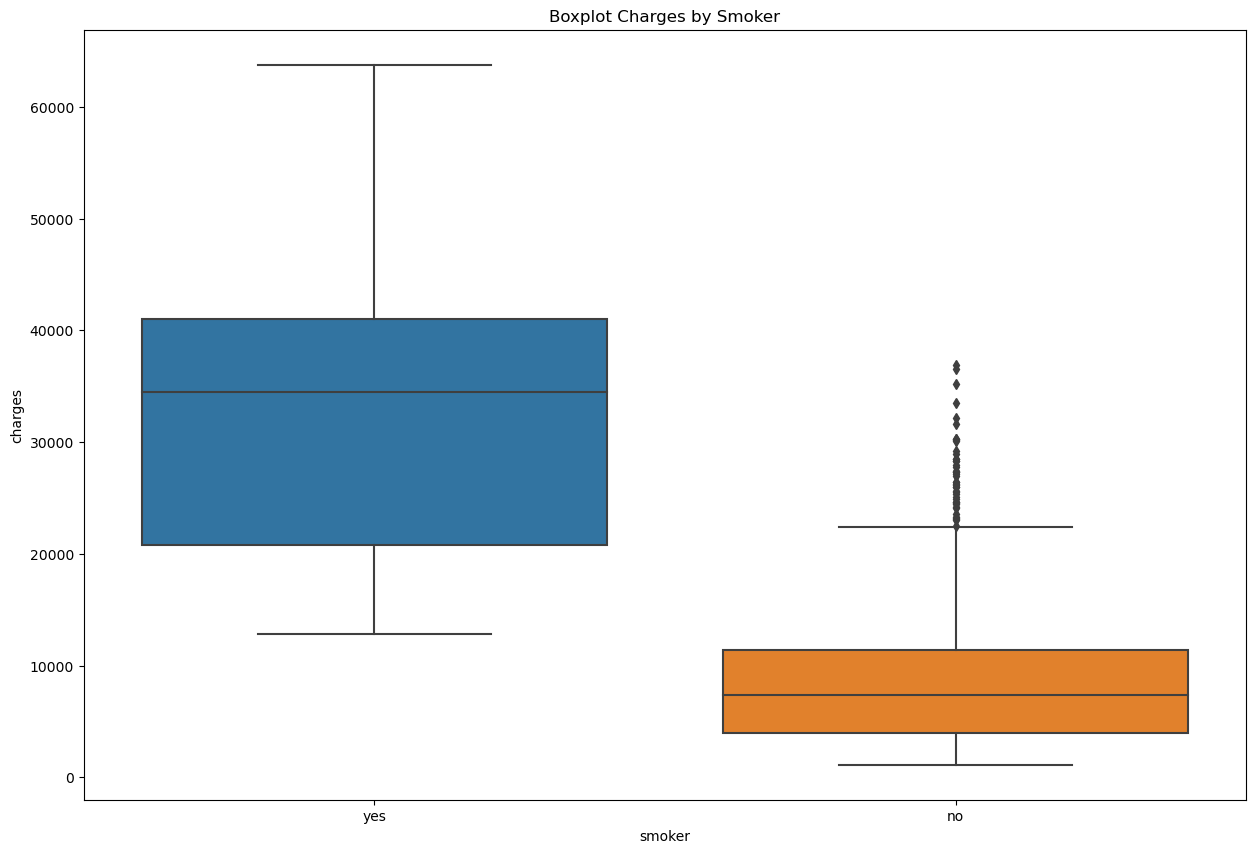

In [14]:
box('smoker')
plt.title("Boxplot Charges by Smoker")
plt.show()

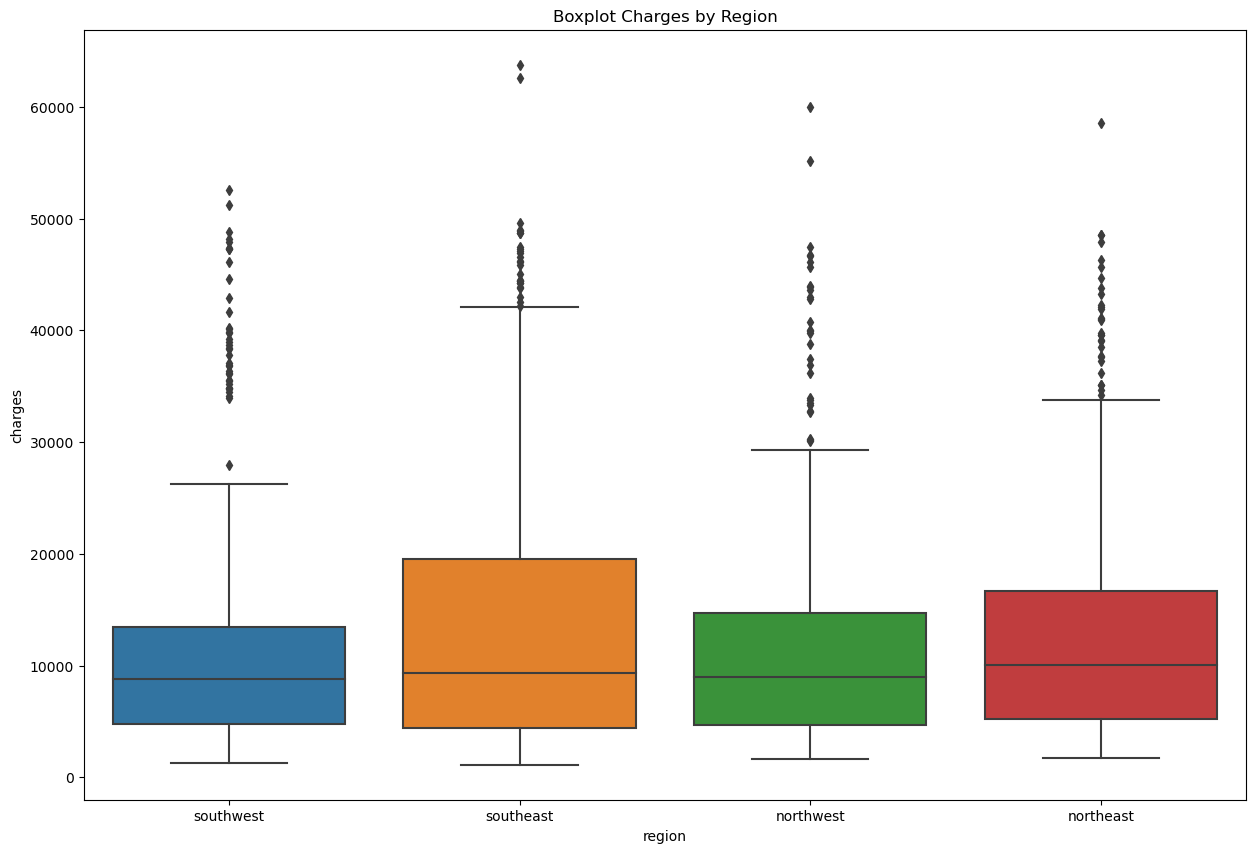

In [15]:
box('region')
plt.title("Boxplot Charges by Region")
plt.show()

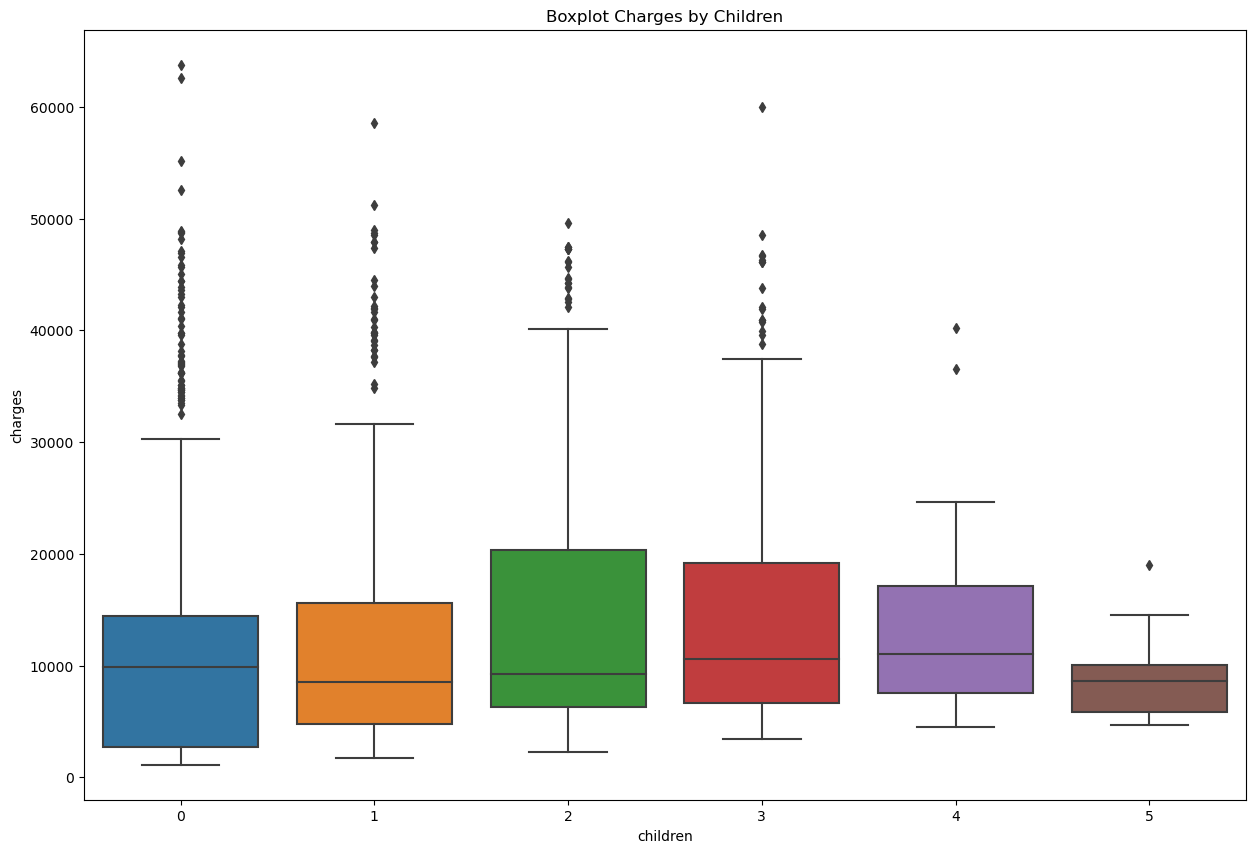

In [16]:
box('children')
plt.title("Boxplot Charges by Children")
plt.show()

# Correlation

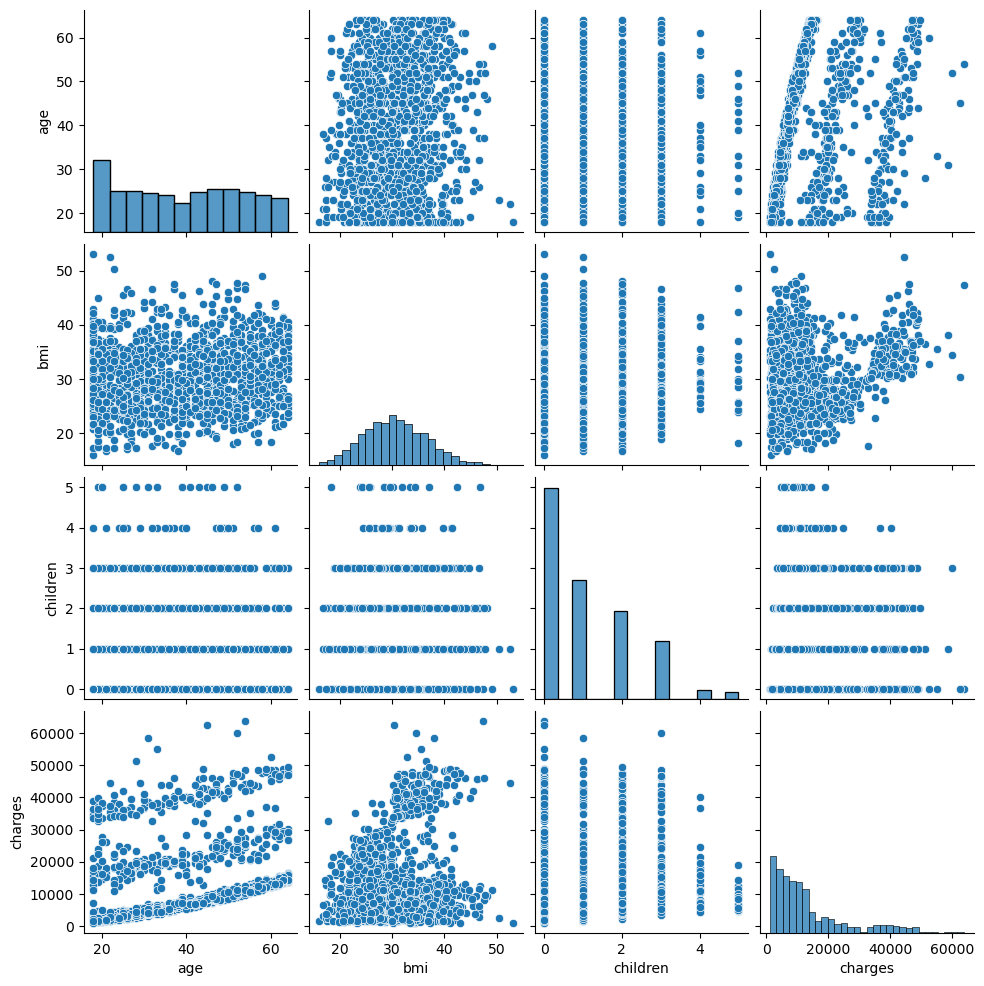

In [17]:
sns.pairplot(insurance)
plt.show()

### - Correlation of age and charges with the condition of smoker or not

In [18]:
def databyregion(reg=None):
    return insurance[insurance['region']==reg] if reg!=None else insurance
def color_smoke(reg):
    return np.where(databyregion(reg).smoker=='yes', 'blue', 'orange')
def scatplot_smoke(param,reg,loc):
#     return sns.scatterplot(data=region(reg),x=param,y='charges',hue='smoker',
#                              ax=axes[loc])
    return databyregion(reg).plot(param, 'charges', s=30, 
                             kind='scatter', 
                             c=color_smoke(reg),
                             ax=axes[loc], subplots=True)

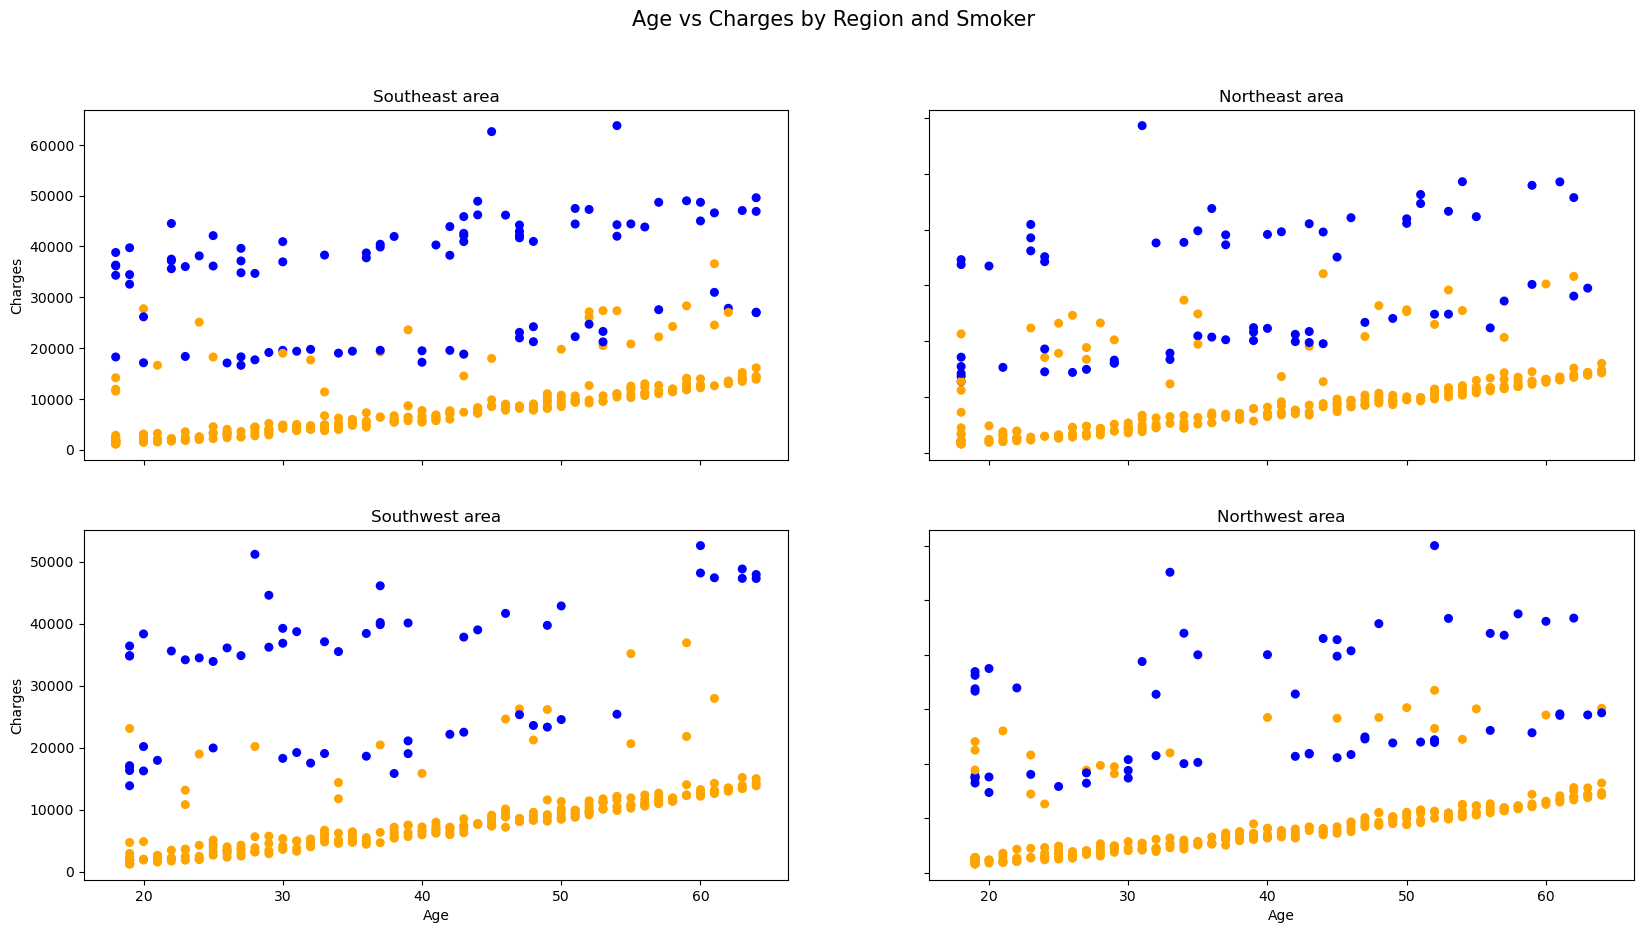

In [19]:
fig, axes = plt.subplots(2,2,figsize=(20,10), sharex=True)
scatplot_smoke('age','southeast',(0,0))
axes[0,0].set_title("Southeast area")

scatplot_smoke('age','northeast',(0,1))
axes[0,1].set_title("Northeast area")

scatplot_smoke('age','southwest',(1,0))
axes[1,0].set_title("Southwest area")

scatplot_smoke('age','northwest',(1,1))
axes[1,1].set_title("Northwest area")

for ax in axes.flat:
    ax.set(xlabel='Age',ylabel='Charges')
    ax.label_outer()

# fig.legend(['Smoker','Non-smoker'])

fig.suptitle('Age vs Charges by Region and Smoker',fontsize=15)
    
plt.show()

It's possible to see that we have 3 groups of charges. The non-smokers are the cheapest insurance, smokers are the most expensives and the third group we still can't say their definition

### - Correlation of BMI and charges with the condition of smoker or not

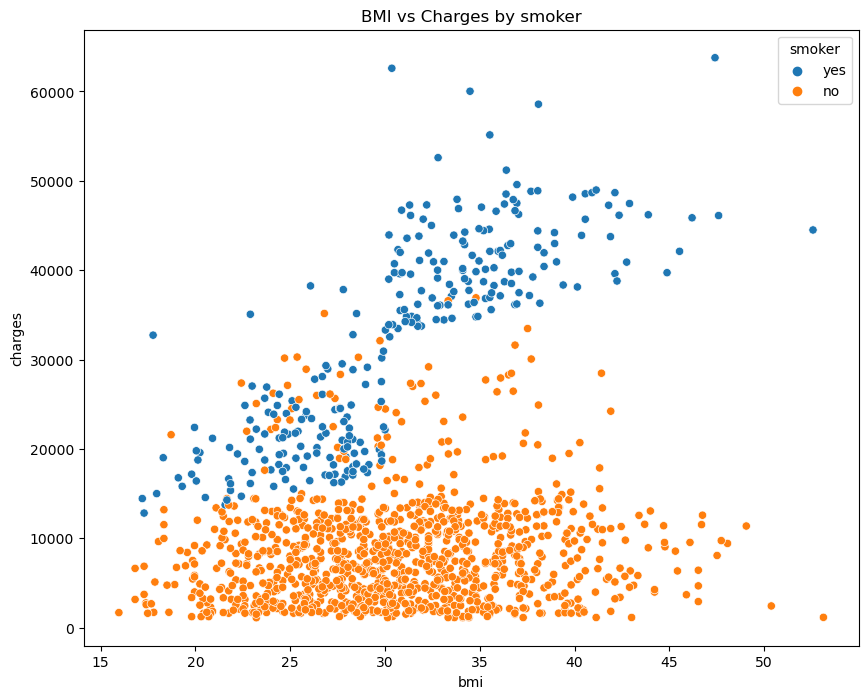

In [20]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=insurance.bmi,y=databyregion().charges,hue=databyregion().smoker)
plt.title('BMI vs Charges by smoker')
plt.show()

Now, we can see a correlation of smokers and bmi greater or under BMI 30, But we still can't tell about the non-smokers

### - Correlation of age and charges with the condition of gender

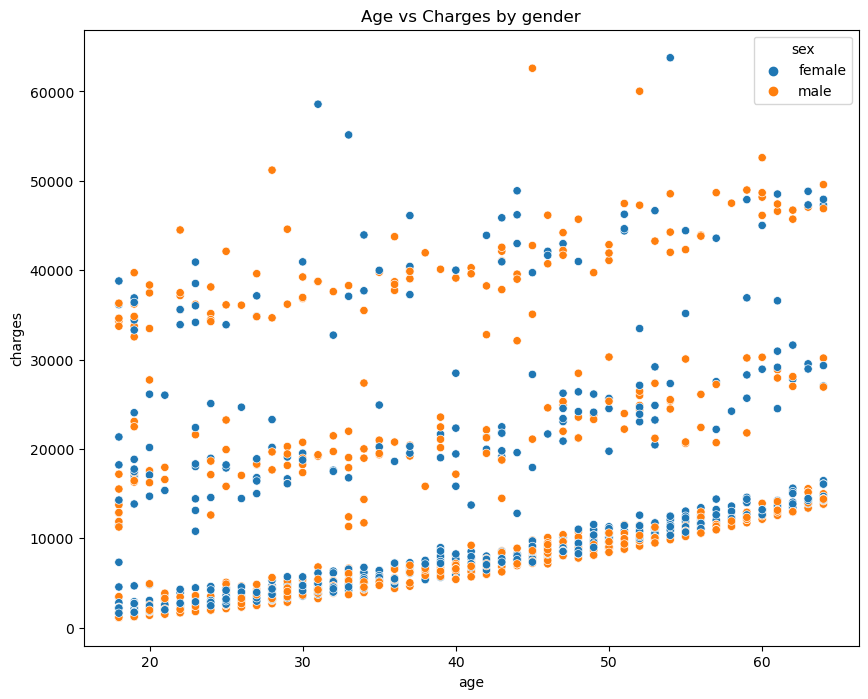

In [21]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=insurance.age,y=databyregion().charges,hue=databyregion().sex)
plt.title('Age vs Charges by gender')
plt.show()

### - Correlation of age and charges with the condition of gender

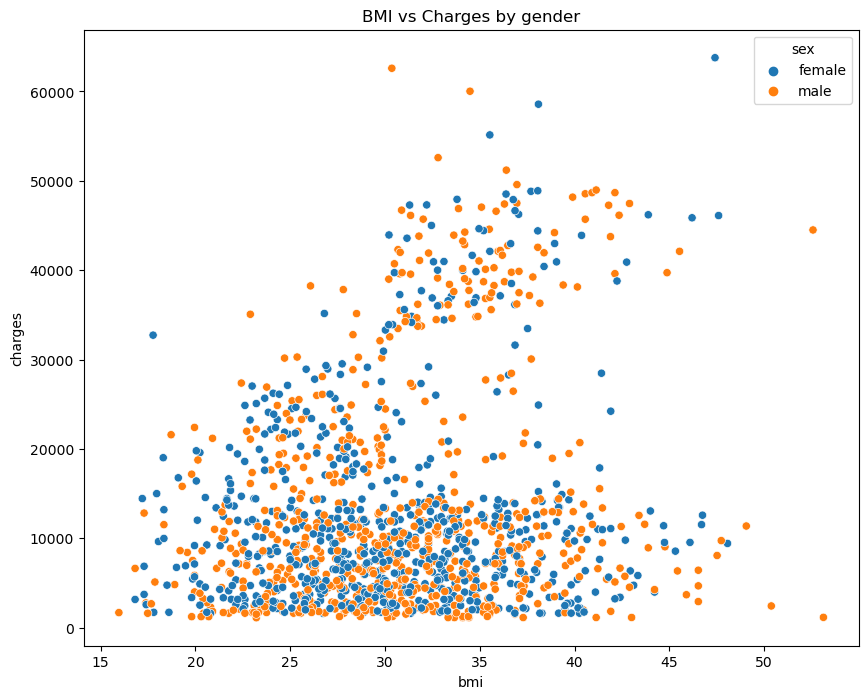

In [22]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=insurance.bmi,y=databyregion().charges,hue=databyregion().sex)
plt.title('BMI vs Charges by gender')
plt.show()

We can't see a correlation of gender

### - All parametes correlation of Charges

In [23]:
insurance_check = insurance.copy()
#sex
cat_cols = LabelEncoder()
cat_cols.fit(insurance_check.sex.drop_duplicates()) 
insurance_check['sex_M'] = cat_cols.transform(insurance_check.sex)

# smoker or not
cat_cols.fit(insurance_check.smoker.drop_duplicates()) 
insurance_check['smoker_Y'] = cat_cols.transform(insurance_check.smoker)

#region
cat_cols.fit(insurance_check.region.drop_duplicates()) 
insurance_check['region_index'] = cat_cols.transform(insurance_check.region)

In [24]:
insurance_check.corr()['charges'].sort_values()

region_index   -0.006208
sex_M           0.057292
children        0.067998
bmi             0.198341
age             0.299008
smoker_Y        0.787251
charges         1.000000
Name: charges, dtype: float64

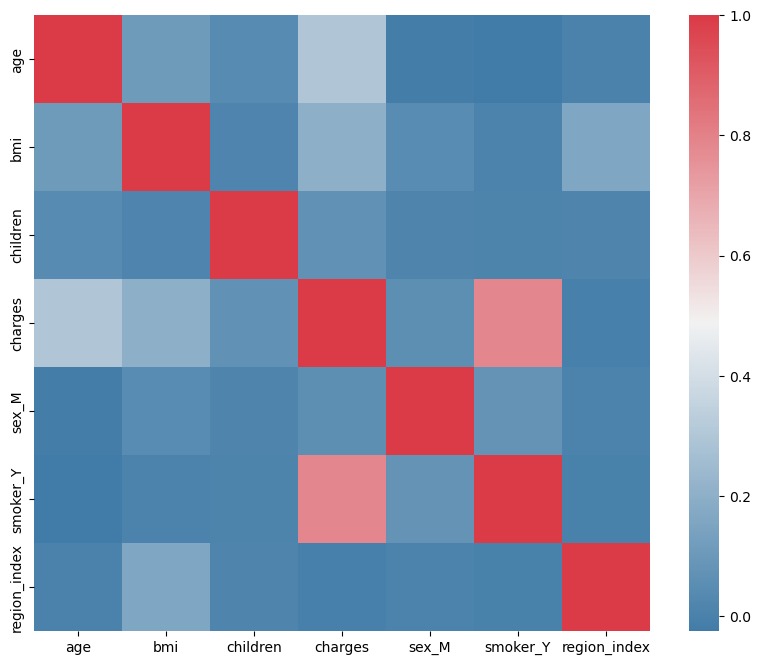

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
corr = insurance_check.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)
plt.show()

# Modeling

### - Model 1

* __Spliting data__

In [26]:
insurance_train, insurance_test = split(insurance, test_size=0.3, 
                              random_state=123456)

* __Transformer__

In [27]:
class Addcolumnindexed():
    def __init__(self):
        pass
    
    def transform(self, X):
        cat_cols = LabelEncoder()
        X_copy=X.copy()
        X_copy[['sex_M', 'smoker_Y','region_index']] = X_copy[['sex', 'smoker','region']].\
                                                    apply(lambda col:cat_cols.fit_transform(col))
        return X_copy
        
    def fit(self, X, y=None):
        return self  

In [28]:
class Columndroptransformer():
    def __init__(self,columns):
        self.columns=columns
        
    def transform(self, X):
        return X.drop(self.columns,axis=1)
        
    def fit(self, X, y=None):
        return self     

In [29]:
pipe = Pipeline([
    ("columnAdd",Addcolumnindexed()),
    ("columnDropper",Columndroptransformer(['sex', 'smoker','region','region_index']))
])

* __Estimator__

In [30]:
X_model1 = pipe.fit_transform(insurance_train).drop(['charges'], axis=1)
y_model1 = pipe.fit_transform(insurance_train)['charges']


In [31]:
insurance_lm = LinearRegression().fit(X_model1, y_model1)

In [32]:
formula = 'charges = ' + f'{insurance_lm.intercept_:.3f}'
for coef, feature in zip(insurance_lm.coef_, X_model1.columns[:6]):
    formula += f'{coef:+.3f}*{feature}'
print(formula)

charges = -12800.186+264.613*age+341.092*bmi+528.027*children-360.960*sex_M+24178.039*smoker_Y


* __Apply the model__

In [33]:
insurance_train['charges pred.'] = insurance_lm.predict(X_model1)
insurance_train[['charges pred.','charges']].describe()

,charges pred.,charges
count,936.000000,936.000000
mean,13345.038524,13345.038524
std,10660.380363,12281.526272
min,-2954.283595,1131.506600
25%,5708.803999,4710.601913
50%,10444.717575,9373.744050
75%,15590.673684,16924.528350
max,41838.126310,63770.428010


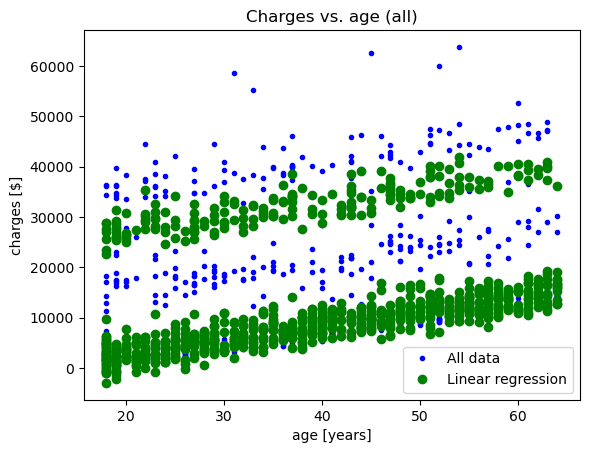

In [34]:
plt.figure()
plt.plot(insurance_train.age, insurance_train.charges, '.b')
plt.plot(insurance_train.age, insurance_train['charges pred.'], 
         'o', color='g')
plt.xlabel('age [years]')
plt.ylabel('charges [$]')
plt.title('Charges vs. age (all)')
plt.legend(['All data', 'Linear regression'], loc='best');

* __Model assessment__

In [35]:
rmse_model1_train = mean_squared_error(y_true=insurance_train['charges pred.'], 
                          y_pred=insurance_train['charges'], 
                          squared=False)
print(" RMSE = {:.2f}".format(rmse_model1_train),"\n",f"Score = {insurance_lm.score(X_model1,y_model1):.5f}")

 RMSE = 6095.28 
 Score = 0.75343


* __Validate the model__

In [36]:
X_model1_test = pipe.fit_transform(insurance_test).drop(['charges'], axis=1)
y_model1_test = pipe.fit_transform(insurance_test)['charges']
insurance_test['charges pred.'] = insurance_lm.predict(X_model1_test)
insurance_test[['charges pred.','charges']].describe()

,charges pred.,charges
count,402.000000,402.000000
mean,13463.316076,13096.688886
std,10718.101827,11714.104906
min,-1701.100914,1121.873900
25%,6020.989140,4773.430700
50%,10312.896003,9394.454850
75%,15692.387548,16007.119875
max,41614.928843,51194.559140


In [37]:
rmse_model1_test = mean_squared_error(y_true=y_model1_test, 
                          y_pred=insurance_test['charges pred.'], 
                          squared=False)
print(" RMSE = {:.2f}".format(rmse_model1_test),"\n",f"Score = {insurance_lm.score(X_model1_test,y_model1_test):.5f}")

 RMSE = 5983.88 
 Score = 0.73841


* __Actual vs Predicted__

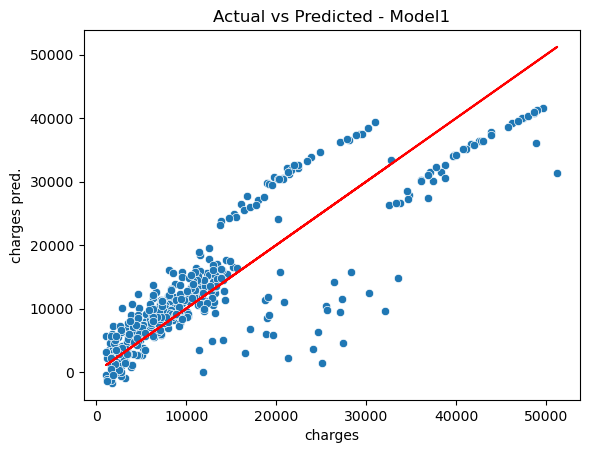

In [38]:
sns.scatterplot(x=y_model1_test,y=insurance_test['charges pred.'])
plt.plot(y_model1_test,y_model1_test,c='r')
plt.title('Actual vs Predicted - Model1')
plt.show()

### - Model 2

* __Spliting data__

In [39]:
insurance_train, insurance_test = split(insurance, test_size=0.3, 
                              random_state=123456)

In [40]:
insurance_train.head()

,age,sex,bmi,children,smoker,region,charges
259,19,male,31.92,0,yes,northwest,33750.2918
720,51,female,40.66,0,no,northeast,9875.6804
735,49,female,34.77,1,no,northwest,9583.8933
921,62,female,33.20,0,no,southwest,13462.5200
979,36,female,29.92,0,no,southeast,4889.0368


* __Transformer__

In [41]:
class Columnaddtransformer():
    def __init__(self):
        pass
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['bmi>30&smoker'] = np.where((X_copy['bmi']>30)&(X_copy['smoker']=='yes'),1,0)
        X_copy['bmi<30&smoker'] = np.where((X_copy['bmi']<30)&(X_copy['smoker']=='yes'),1,0)
        X_copy['bmi>30&nosmoker'] = np.where((X_copy['bmi']>30)&(X_copy['smoker']=='no'),1,0)
        X_copy['bmi<30&nosmoker'] = np.where((X_copy['bmi']<30)&(X_copy['smoker']=='no'),1,0)
        return X_copy
        
    def fit(self, X, y=None):
        return self  

In [42]:
class Columndroptransformer():
    def __init__(self,columns):
        self.columns=columns
        
    def transform(self, X):
        return X.drop(self.columns,axis=1)
        
    def fit(self, X, y=None):
        return self       

In [43]:
pipe2 = Pipeline([
    ("columnAdd",Columnaddtransformer()),
    ("columnDropper",Columndroptransformer(['children','sex','region','bmi','smoker']))
])

* __Estimator__

In [44]:
X_model2 = pipe2.fit_transform(insurance_train).drop(['charges'], axis=1)
y_model2 = pipe2.fit_transform(insurance_train)['charges']

In [45]:
insurance_model2_lm = LinearRegression().fit(X_model2, y_model2)

In [46]:
formula = 'charges = ' + f'{insurance_model2_lm.intercept_:.3f}'
for coef, feature in zip(insurance_model2_lm.coef_, X_model2.columns[:6]):
    formula += f'{coef:+.3f}*{feature}'
print(formula)

charges = 3157.070+275.500*age+27979.659*bmi>30&smoker+7668.169*bmi<30&smoker-5625.908*bmi>30&nosmoker-5545.699*bmi<30&nosmoker


* __Apply the model__

In [47]:
insurance_train['charges pred.'] = insurance_model2_lm.predict(X_model2)
insurance_train[['charges pred.','charges']].describe()

,charges pred.,charges
count,936.000000,936.000000
mean,13345.038524,13345.038524
std,11402.207287,12281.526272
min,2490.156446,1131.506600
25%,5600.862455,4710.601913
50%,10204.148491,9373.744050
75%,14336.644230,16924.528350
max,48493.211085,63770.428010


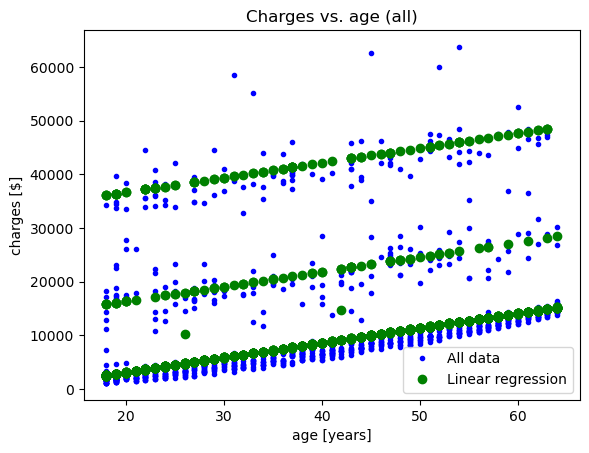

In [48]:
plt.figure()
plt.plot(insurance_train.age, insurance_train.charges, '.b')
plt.plot(insurance_train.age, insurance_train['charges pred.'], 
         'o', color='g')
plt.xlabel('age [years]')
plt.ylabel('charges [$]')
plt.title('Charges vs. age (all)')
plt.legend(['All data', 'Linear regression'], loc='best');

* __Assess the model__

In [49]:
rmse_model2_train = mean_squared_error(y_true=insurance_train['charges pred.'], 
                          y_pred=insurance_train['charges'], 
                          squared=False)
print(" RMSE = {:.2f}".format(rmse_model2_train),"\n",f"Score = {insurance_model2_lm.score(X_model2,y_model2):.5f}")

 RMSE = 4561.06 
 Score = 0.86193


In [50]:
rmsle_model2_train = mean_squared_log_error(y_true=insurance_train['charges pred.'],\
                                                            y_pred=insurance_train['charges'])
print(" RMSLE = {:.3f}".format(rmsle_model2_train))

 RMSLE = 0.168


* __Validate the model__

In [51]:
X_model2_test = pipe2.fit_transform(insurance_test).drop(['charges'], axis=1)
y_model2_test = pipe2.fit_transform(insurance_test)['charges']
insurance_test['charges pred.'] = insurance_model2_lm.predict(X_model2_test)
insurance_test[['charges pred.','charges']].describe()

,charges pred.,charges
count,402.000000,402.000000
mean,13094.109892,13096.688886
std,11132.391250,11714.104906
min,2490.156446,1121.873900
25%,5876.362171,4773.430700
50%,10382.002917,9394.454850
75%,14336.644230,16007.119875
max,48768.710801,51194.559140


In [52]:
rmse_model2_test = mean_squared_error(y_true=y_model2_test, 
                          y_pred=insurance_test['charges pred.'], 
                          squared=False)
print(" RMSE = {:.2f}".format(rmse_model2_test),"\n",f"Score = {insurance_model2_lm.score(X_model2_test,y_model2_test):.5f}")

 RMSE = 4460.83 
 Score = 0.85462


In [53]:
rmsle_model2_test = mean_squared_log_error(y_true=y_model2_test,\
                                                            y_pred=insurance_test['charges pred.'])
print(" RMSLE = {:.3f}".format(rmsle_model2_test))

 RMSLE = 0.185


* __Actual vs Predicted__

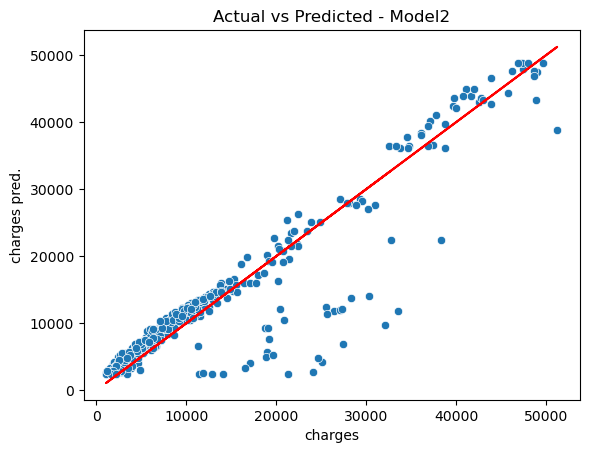

In [54]:
sns.scatterplot(x=y_model2_test,y=insurance_test['charges pred.'])
plt.plot(y_model2_test,y_model2_test,c='r')
plt.title('Actual vs Predicted - Model2')
plt.show()

### - Model 3  - Decision Tree Regression

 __Spliting data__

In [55]:
insurance_train, insurance_test = split(insurance, test_size=0.3, 
                              random_state=123456)

insurance_train.head()

,age,sex,bmi,children,smoker,region,charges
259,19,male,31.92,0,yes,northwest,33750.2918
720,51,female,40.66,0,no,northeast,9875.6804
735,49,female,34.77,1,no,northwest,9583.8933
921,62,female,33.20,0,no,southwest,13462.5200
979,36,female,29.92,0,no,southeast,4889.0368


 __Transformer__

In [56]:
pipe3 = Pipeline([
    ("columnAdd",Addcolumnindexed()),
    ("columnDropper",Columndroptransformer(['sex', 'smoker','region']))
])

In [57]:
class ColCatRep():
    def __init__(self):
        pass
    
  
    def transform(self, X):
        X_copy = X.copy()
        X_copy['sex'] = X_copy['sex'].replace({'male': False, 'female': True})
        X_copy['smoker'] = X_copy['smoker'].replace({'no': False, 'yes': True})
        X_copy['region'] = X_copy['region'].replace({'northwest':0, 'southwest':1, 'northeast':2, 'southeast':3})
        return X_copy
        
    def fit(self, X, y=None):
        return self  
    

In [58]:
pipe3 = make_pipeline(ColCatRep())


In [59]:
X_train_model3 = pipe3.fit_transform(insurance_train).drop(['charges'], axis=1)
y_train_model3 = pipe3.fit_transform(insurance_train)['charges']


In [60]:
insurance_model3_lm = DecisionTreeRegressor(min_samples_leaf=15, 
                                            max_leaf_nodes=10,
                                            max_depth=3)

insurance_model3_lm.fit(X_train_model3, y_train_model3)

DecisionTreeRegressor(max_depth=3, max_leaf_nodes=10, min_samples_leaf=15)

In [61]:
def visualize_tree(insurance_model3_lm, md=5, fs=(12, 8)):
    plt.figure(figsize=fs)
    plot_tree(insurance_model3_lm,
            max_depth=md,
            feature_names=insurance_model3_lm.feature_names_in_,
            label='all',
            filled=True,
            rounded=True, 
            fontsize=12);

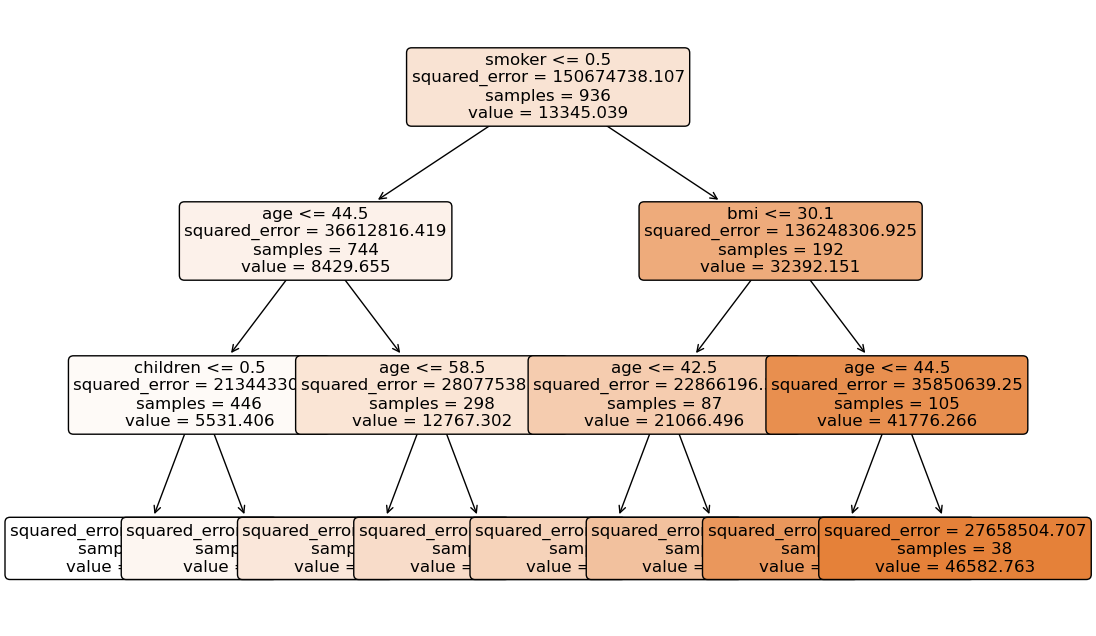

In [62]:
visualize_tree(insurance_model3_lm, md=5)

In [63]:
insurance_train['charges pred.'] = insurance_model3_lm.predict(X_train_model3)
insurance_train[['charges pred.','charges']].describe()

,charges pred.,charges
count,936.000000,936.000000
mean,13345.038524,13345.038524
std,11392.868460,12281.526272
min,3790.888095,1131.506600
25%,6859.152220,4710.601913
50%,11825.416436,9373.744050
75%,15567.843046,16924.528350
max,46582.762746,63770.428010


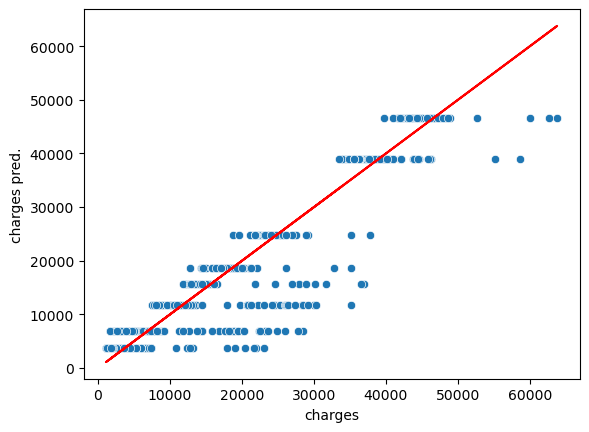

In [64]:
ax = sns.scatterplot(x=y_train_model3, y=insurance_train['charges pred.'])
ax.plot(y_train_model3, y_train_model3, 'r')

In [65]:
RMSE = mse(y_train_model3, insurance_train['charges pred.'])**0.5
RMSE

4584.316618909581

In [66]:
rmsle_model3_train = mean_squared_log_error(y_true=y_train_model3,\
                                                            y_pred=insurance_train['charges pred.'])
print(" RMSLE = {:.3f}".format(rmsle_model3_train))

 RMSLE = 0.214


__Validating the model__

In [67]:
X_test_model3 = pipe3.fit_transform(insurance_test).drop(['charges'], axis=1)
y_test_model3 = pipe3.fit_transform(insurance_test)['charges']

In [68]:
insurance_test['charges pred.'] = insurance_model3_lm.predict(X_test_model3)
insurance_test[['charges pred.','charges']].describe()

,charges pred.,charges
count,402.000000,402.000000
mean,13208.707378,13096.688886
std,10833.187635,11714.104906
min,3790.888095,1121.873900
25%,6859.152220,4773.430700
50%,11825.416436,9394.454850
75%,15567.843046,16007.119875
max,46582.762746,51194.559140


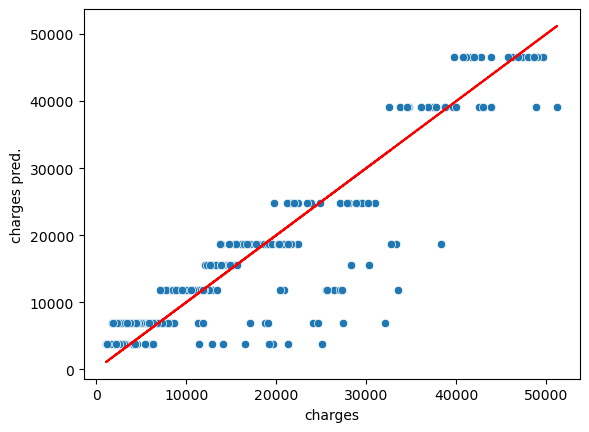

In [69]:
ax = sns.scatterplot(x=y_test_model3, y=insurance_test['charges pred.'])
ax.plot(y_test_model3, y_test_model3, 'r')

In [70]:
RMSE = mse(y_test_model3, insurance_test['charges pred.'])**0.5
RMSE

4844.012402730145

In [71]:
rmsle_model3_test = mean_squared_log_error(y_true=y_test_model3,\
                                                            y_pred=insurance_test['charges pred.'])
print(" RMSLE = {:.3f}".format(rmsle_model3_test))

 RMSLE = 0.241
